In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from scipy.stats import multivariate_normal as mvn
import nltk
import os
import random




import string
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# email module has some useful functions
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import os, sys, email,re
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['emails.csv']


In [2]:
df = pd.read_csv('../input/emails.csv',nrows = 35000)
df.shape

(35000, 2)

# Main Analysis Starts Here
## Use the Email module to extract raw text

In [3]:
# create list of email objects
emails = list(map(email.parser.Parser().parsestr,df['message']))

# extract headings such as subject, from, to etc..
headings  = emails[0].keys()

# Goes through each email and grabs info for each key
# doc['From'] grabs who sent email in all emails
for key in headings:
    df[key] = [doc[key] for doc in emails]

In [4]:
##Useful functions
def get_raw_text(emails):
    email_text = []
    for email in emails.walk():
        if email.get_content_type() == 'text/plain':
            email_text.append(email.get_payload())
    return ''.join(email_text)

df['body'] = list(map(get_raw_text, emails))
df.head()
df['user'] = df['file'].map(lambda x: x.split('/')[0])

In [5]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.head()
df.dtypes

file                                 object
message                              object
Message-ID                           object
Date                         datetime64[ns]
From                                 object
To                                   object
Subject                              object
Mime-Version                         object
Content-Type                         object
Content-Transfer-Encoding            object
X-From                               object
X-To                                 object
X-cc                                 object
X-bcc                                object
X-Folder                             object
X-Origin                             object
X-FileName                           object
body                                 object
user                                 object
dtype: object

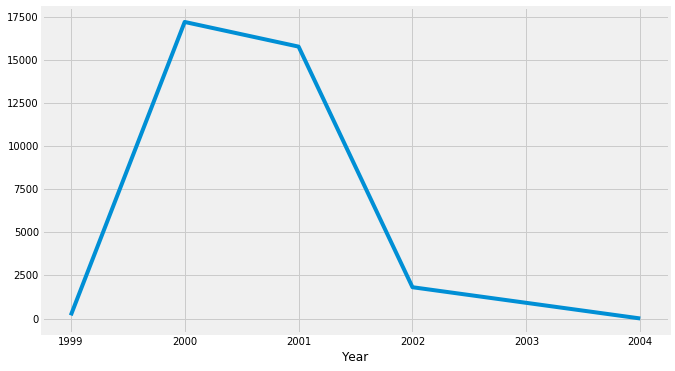

In [6]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.dayofweek

# reduce the sample period
# looks like the total number of emails really ramped up in 2000 and 2001
indices = (df['Year'] > 1995) & (df['Year'] <= 2004)
plt.figure(figsize = (10,6))
figure1 = df.loc[indices].groupby('Year')['body'].count().plot()

In [7]:
df.Year.agg({'max': max, 'min': min})
# really should not be dates up to 2044
df[df['Year']==2044]

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,body,user,Month,Year,Day


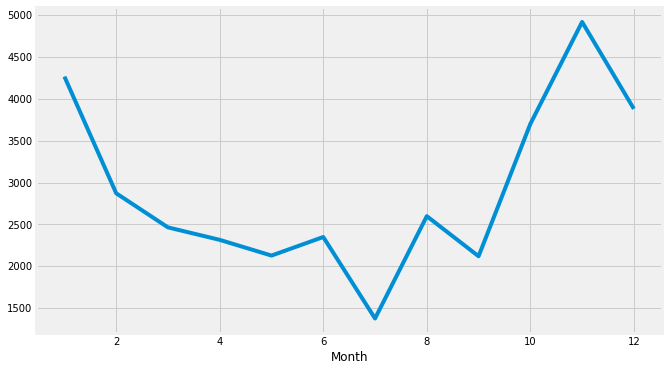

In [8]:
plt.figure(figsize = (10,6))
figure2 = df.groupby('Month')['body'].count().plot()

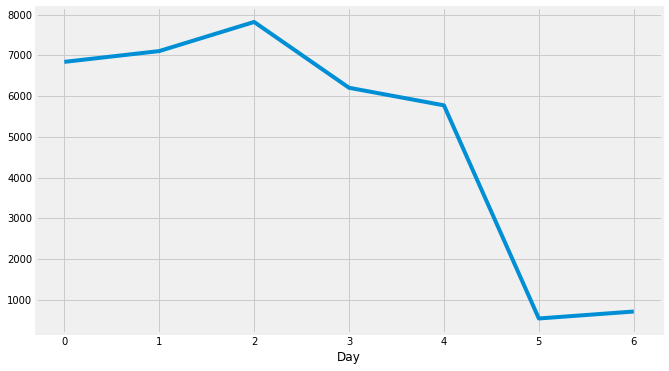

In [9]:
plt.figure(figsize = (10,6))
figure3 = df.groupby('Day')['body'].count().plot()

In [10]:
#Unique to and From
print('Total number of emails: %d' %len(df))
print('------------')
print('Number of unique received: %d '%df['To'].nunique())
print('------------')
print('Number of unique Sent: %d '%df['From'].nunique())

Total number of emails: 35000
------------
Number of unique received: 4926 
------------
Number of unique Sent: 2151 


### Most frequent Senders and receivers of Emails

In [11]:
top_10_frequent = df.groupby('user')['file'].count().sort_values(ascending = False)[:30]
top_10_frequent

user
beck-s        11830
bass-e         7823
arnold-j       4898
allen-p        3034
baughman-d     2760
blair-l        1879
badeer-r        877
benson-r        767
arora-h         654
bailey-s        478
Name: file, dtype: int64

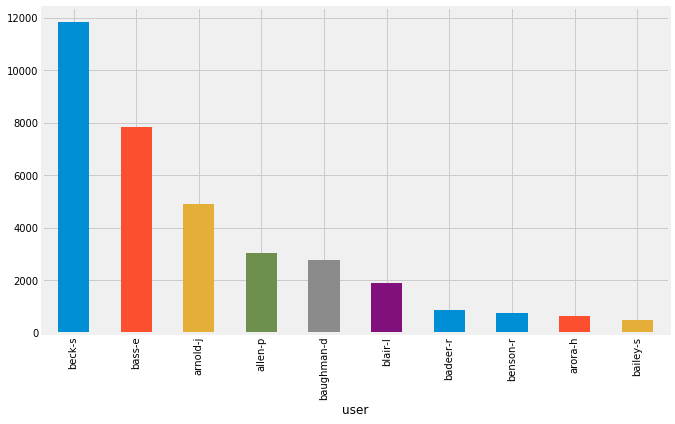

In [12]:
plt.figure(figsize = (10,6))
top_10_frequent.plot(kind = 'bar')

## Users and number of emails they sent by year.
- huge increase in quantity of emails in the early 2000's

In [13]:
df.groupby(['user', 'Year'])['file'].count()

user        Year
allen-p     1980      10
            1999       8
            2000    1307
            2001    1704
            2002       5
arnold-j    1980       8
            2000    1832
            2001    3056
            2002       2
arora-h     1980       2
            2000      62
            2001     580
            2002      10
badeer-r    2000     851
            2001       2
            2002      24
bailey-s    2000       1
            2001     127
            2002     350
bass-e      1980       6
            1999      81
            2000    5727
            2001    1534
            2002     473
            2004       2
baughman-d  1980       6
            2000     176
            2001    2145
            2002     433
beck-s      1980      16
            1999      94
            2000    7235
            2001    4095
            2002     390
benson-r    2001     646
            2002     121
blair-l     2001    1873
            2002       6
Name: file, dtype: int64

## Check whether emails were to a single person or multiple people

In [14]:
def split_data(data):
    if data is not None:
        temp = data.split(',')
        if len(temp) == 1:
            return 'Direct'
        else:
            return 'Multiple'
    else:
        return 'Empty'
df['Direct_or_multi'] = df['To'].apply(split_data)

## Top 10 most frequent emailers
- Interestingly all kaminski's emails were sent directly to people
- This could warrent a closer look: who were the ppl he was emailing.

In [15]:
df.groupby('user')['Direct_or_multi'].value_counts().sort_values(ascending=False)[:15]

user        Direct_or_multi
beck-s      Direct             7595
bass-e      Direct             5900
arnold-j    Direct             4354
beck-s      Multiple           3960
allen-p     Direct             2631
bass-e      Multiple           1738
baughman-d  Direct             1327
            Multiple           1311
blair-l     Empty               723
            Multiple            656
badeer-r    Direct              544
arora-h     Direct              505
blair-l     Direct              500
arnold-j    Multiple            408
allen-p     Multiple            340
Name: Direct_or_multi, dtype: int64

## Clean the subject columns

In [16]:
def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        # removes punctuation
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        # strip html 
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        data = re.sub('forwarded by phillip k allenhouect on    pm', '',data)
        data = re.sub(r"httpitcappscorpenroncomsrrsauthemaillinkaspidpage", "", data)
        
        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'


df['Subject_new'] = df['Subject'].apply(clean_column)
df['body_new'] = df['body'].apply(clean_column)

In [17]:
df['body_new'].head(50)

0                                  here is our forecast
1     traveling to have a business meeting takes the...
2                            test successful  way to go
3     randy   can you send me a schedule of the sala...
4                             lets shoot for tuesday at
5     greg   how about either next tuesday or thursd...
6     please cc the following distribution list with...
7                              any morning between  and
8     login  pallen pw kedavis   i dont think these ...
9     buckner buck buckbucknerhoneywellcom on   pm t...
10    mr buckner   for delivered gas behind san dieg...
11    lucy   here are the rentrolls     open them an...
12    richard burchfield   am to phillip k allenhoue...
13    richard burchfield   am to phillip k allenhoue...
14    dave    here are the names of the west desk me...
15                    paula    million is fine  phillip
16    enron north america corp \t \tfrom  airam arte...
17    tim  mike grigsby is having problems with 

In [18]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

## Visualise Email Subject

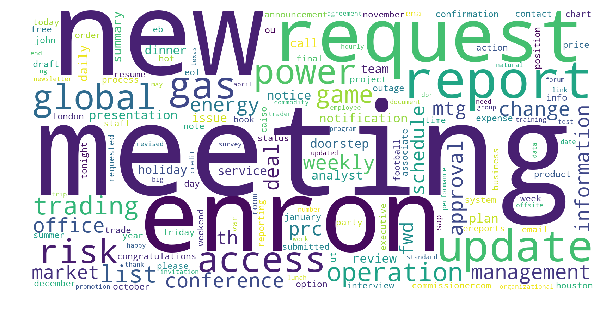

In [19]:
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(df['Subject_new'])) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [20]:
stemmer = PorterStemmer()
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [21]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

## TF-IDF tranformation for K-means algorithm

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = df['body_new']
# data.head()

tf_idf_vectorizor = TfidfVectorizer(stop_words = stopwords,#tokenizer = tokenize_and_stem,
                             max_features = 5000)
%time tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

/opt/conda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'fw', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 6.64 s, sys: 96 ms, total: 6.73 s
Wall time: 6.73 s


,aaron,abc,abcsubstringabclength,abel,abelhouectect,ability,able,absence,absolutely,ac,academy,accept,acceptable,acceptance,accepted,access,accessible,accessing,accommodate,accommodations,accomplish,accomplishments,according,accordingly,account,accounting,accounts,accrual,accuracy,accurate,accurately,achieve,acknowledge,acquire,acquired,acquiring,acquisition,acquisitions,across,act,...,writing,written,wrong,wrote,wrs,wti,wynn,xms,xp,ya,yahoo,yall,yard,yards,yea,yeah,year,yearend,yearold,years,yes,yesterday,yesterdays,yet,yo,york,youd,youll,young,youre,youve,ypc,yvette,zadow,zdnet,zero,zhiyong,zip,zipper,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100491,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Kmeans Class 

## test pairwise function

In [23]:
# initial_centroids = np.random.permutation(tf_idf_array.shape[0])[:3]
# initial_centroids
# centroids = tf_idf_array[initial_centroids]
# centroids.shape
# dist_to_centroid =  pairwise_distances(tf_idf_array,centroids, metric = 'euclidean')
# cluster_labels = np.argmin(dist_to_centroid, axis = 1)

In [24]:
class Kmeans:
    """ K Means Clustering
    
    Parameters
    -----------
        k: int , number of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids
    
    
    def assign_clusters(self, data):
        """Compute distance of data from clusters and assign data point
           to closest cluster.
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
            
        """
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    
    def update_centroids(self, data):
        """Computes average of all data points in cluster and
           assigns new centroids as average of data points
        
        Parameters
        -----------
        data: array or matrix, number_rows, number_features
        
        Returns
        -----------
        centroids: array, k, number_features
        """
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        
        return self.centroids
    
    
    def convergence_calculation(self):
        """
        Calculates 
        
        """
        pass
    
    def predict(self, data):
        """Predict which cluster data point belongs to
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
        """
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        """
        This function contains the main loop to fit the algorithm
        Implements initialise centroids and update_centroids
        according to max_iter
        -----------------------
        
        Returns
        -------
        instance of kmeans class
            
        """
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self    

# My Implementation

array([-2.30970265,  5.8496944 ])

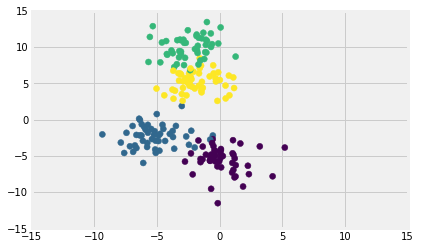

In [25]:
from sklearn.datasets import make_blobs
# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
# create scatter plot
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)

X = data[0]
X[2]

In [26]:
temp_k  = Kmeans(4, 1, 600)
temp_fitted  = temp_k.fit_kmeans(X)
new_data = np.array([[1.066, -8.66],
                    [1.87876, -6.516],
                    [-1.59728965,  8.45369045],
                    [1.87876, -6.516]])
temp_fitted.predict(new_data)

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


array([2, 2, 1, 2])

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running
CPU times: user 2.39 s, sys: 8 ms, total: 2.4 s
Wall time: 2.39 s


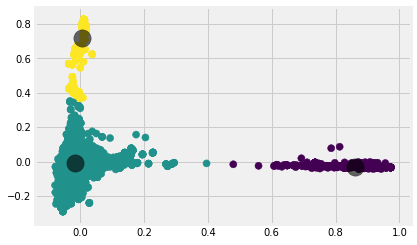

In [27]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(3, 1, 600)
%time fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

# SK learn Implementation

CPU times: user 220 ms, sys: 292 ms, total: 512 ms
Wall time: 131 ms


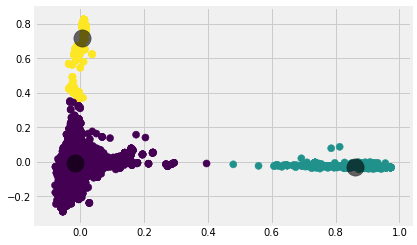

In [28]:
from sklearn.cluster import KMeans
n_clusters = 3
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

# Optimal Clusters

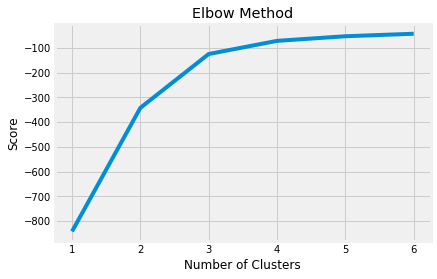

In [29]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

# Extracting top features

In [30]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

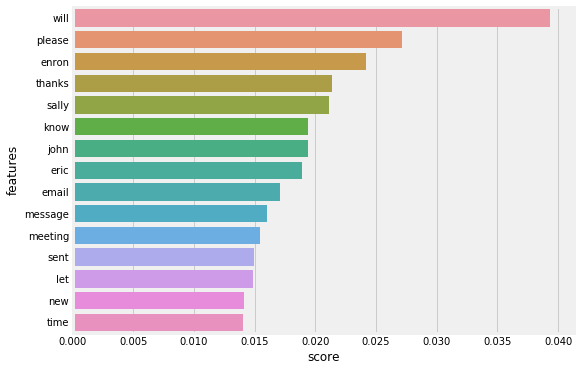

In [31]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

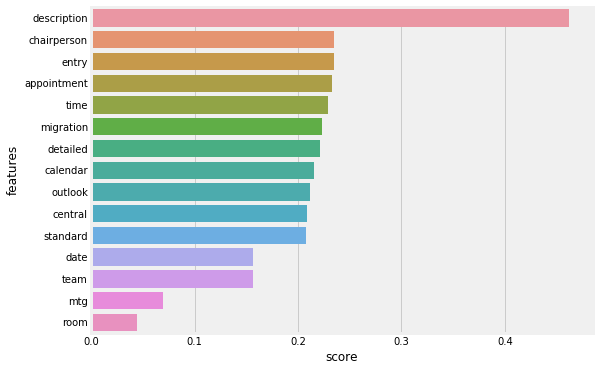

In [32]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

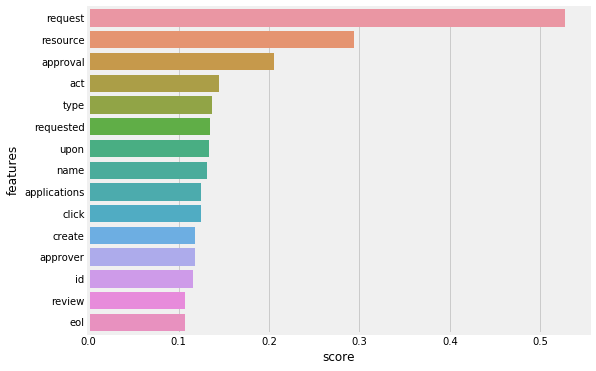

In [33]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

In [34]:
for i, df in enumerate(dfs):
    df.to_csv('df_'+str(i)+'.csv')

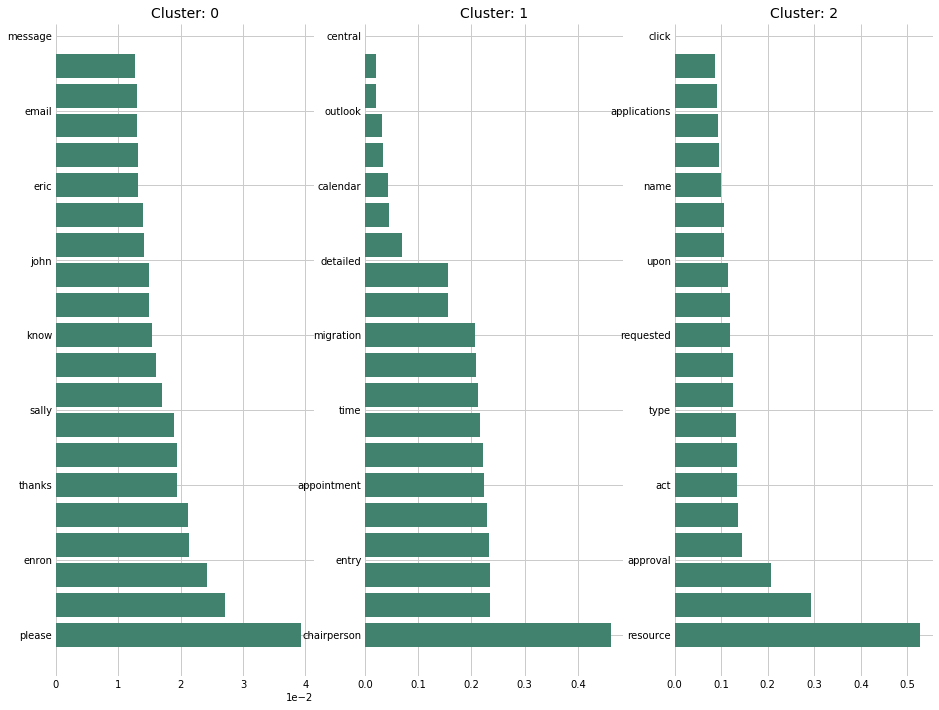

In [35]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)

# GMM in sklearn

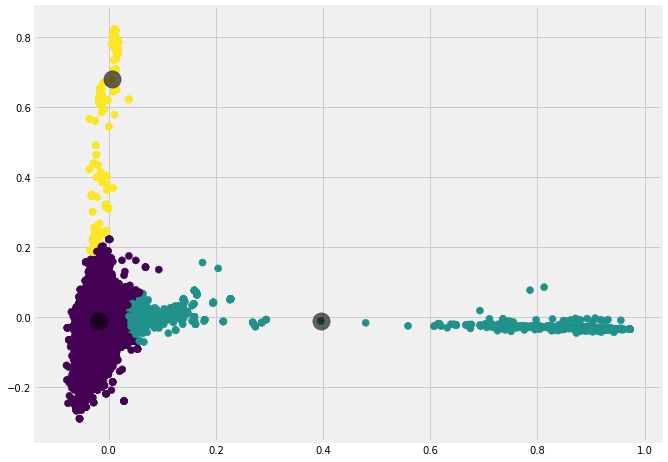

In [36]:

from sklearn.mixture import GaussianMixture
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

# Draw distributions

In [37]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

In [38]:
plt.figure(figsize = (10,8))
from scipy.spatial.distance import cdist
def plot_kmeans(kmeans, X, n_clusters=3, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plot_kmeans(kmeans, Y_sklearn)

AttributeError: 'list' object has no attribute 'fit_predict'

<Figure size 720x576 with 0 Axes>

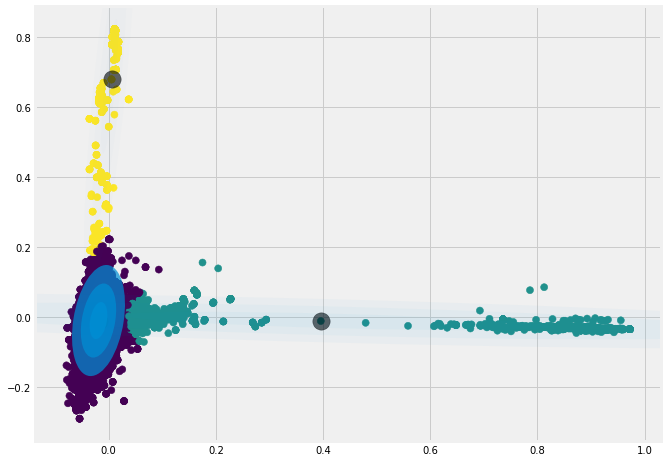

In [39]:
plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis', zorder=1)
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w*.75)

# GMM from scratch

In [40]:
class GMM:
    """ Gaussian Mixture Model
    
    Parameters
    -----------
        k: int , number of gaussian distributions
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    def __init__(self, C, n_runs):
        self.C = C # number of Guassians/clusters
        self.initial_means = None
        self.initial_cov = None
        self.initial_pi = None
        self.n_runs = n_runs
        
    
    def get_params(self):
        return (self.mu, self.pi, self.sigma)
    
    
        
    def calculate_mean_covariance(self, X, prediction):
        """Calculate means and covariance of different
            clusters from k-means prediction
        
        Parameters:
        ------------
        prediction: cluster labels from k-means
        
        X: N*d numpy array data points 
        
        Returns:
        -------------
        intial_means: for E-step of EM algorithm
        
        intial_cov: for E-step of EM algorithm
        
        """
        d = X.shape[1]
        labels = np.unique(prediction)
        self.initial_means = np.zeros((self.C, d))
        self.initial_cov = np.zeros((self.C, d, d))
        self.initial_pi = np.zeros(self.C)
        self.loss = -999999
        
        counter=0
        for label in labels:
            ids = np.where(prediction == label) # returns indices
            self.initial_pi[counter] = len(ids[0]) / X.shape[0]
            self.initial_means[counter,:] = np.mean(X[ids], axis = 0)
            de_meaned = X[ids] - self.initial_means[counter,:]
            Nk = X[ids].shape[0] # number of data points in current gaussian
            self.initial_cov[counter,:, :] = np.dot(self.initial_pi[counter] * de_meaned.T, de_meaned) / Nk
            counter+=1
        assert np.sum(self.initial_pi) == 1    
            
        return (self.initial_means, self.initial_cov, self.initial_pi)
    
    
    
    def _initialise_parameters(self, X):
        """Implement k-means to find starting
            parameter values.
            https://datascience.stackexchange.com/questions/11487/how-do-i-obtain-the-weight-and-variance-of-a-k-means-cluster

        Parameters:
        ------------
        X: numpy array of data points
        
        Returns:
        ----------
        tuple containing initial means and covariance
        
        _initial_means: numpy array: (C*d)
        
        _initial_cov: numpy array: (C,d*d)
        
        
        """
        n_clusters = self.C
        kmeans = KMeans(n_clusters= n_clusters, init="k-means++", max_iter=500, algorithm = 'auto')
        fitted = kmeans.fit(X)
        prediction = kmeans.predict(X)
        self._initial_means, self._initial_cov, self._initial_pi = self.calculate_mean_covariance(X, prediction)
        
        
        return (self._initial_means, self._initial_cov, self._initial_pi)
            
        
        
    def _e_step(self, X, pi, mu, sigma):
        """Performs E-step on GMM model

        Parameters:
        ------------
        X: (N x d), data points, m: no of features
        pi: (C), weights of mixture components
        mu: (C x d), mixture component means
        sigma: (C x d x d), mixture component covariance matrices

        Returns:
        ----------
        gamma: (N x C), probabilities of clusters for objects
        """
        N = X.shape[0] 
        self.gamma = np.zeros((N, self.C))

        const_c = np.zeros(self.C)
        
        
        self.mu = mu if self._initial_means is None else self._initial_means
        self.pi = pi if self._initial_pi is None else self._initial_pi
        self.sigma = sigma if self._initial_cov is None else self._initial_cov

        for c in range(self.C):
            # Posterior Distribution using Bayes Rule
            self.gamma[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])

        # normalize across columns to make a valid probability
        gamma_norm = np.sum(self.gamma, axis=1)[:,np.newaxis]
        self.gamma /= gamma_norm

        return self.gamma
    
    
    def _m_step(self, X, gamma):
        """Performs M-step of the GMM
        We need to update our priors, our means
        and our covariance matrix.

        Parameters:
        -----------
        X: (N x d), data 
        gamma: (N x C), posterior distribution of lower bound 

        Returns:
        ---------
        pi: (C)
        mu: (C x d)
        sigma: (C x d x d)
        """
        N = X.shape[0] # number of objects
        C = self.gamma.shape[1] # number of clusters
        d = X.shape[1] # dimension of each object

        # responsibilities for each gaussian
        self.pi = np.mean(self.gamma, axis = 0)

        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis = 0)[:,np.newaxis]

        for c in range(C):
            x = X - self.mu[c, :] # (N x d)
            
            gamma_diag = np.diag(self.gamma[:,c])
            x_mu = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)

            sigma_c = x.T * gamma_diag * x
            self.sigma[c,:,:]=(sigma_c) / np.sum(self.gamma, axis = 0)[:,np.newaxis][c]

        return self.pi, self.mu, self.sigma
    
    
    def _compute_loss_function(self, X, pi, mu, sigma):
        """Computes lower bound loss function
        
        Parameters:
        -----------
        X: (N x d), data 
        
        Returns:
        ---------
        pi: (C)
        mu: (C x d)
        sigma: (C x d x d)
        """
        N = X.shape[0]
        C = self.gamma.shape[1]
        self.loss = np.zeros(N)

        for c in range(C):
            dist = mvn(self.mu[c], self.sigma[c],allow_singular=True)
            for n in range(N):
                self.loss += self.gamma[n,c]*(np.log(self.pi[c]+0.00001)+dist.logpdf(X[n,:])-np.log(self.gamma[n,c]+0.000001))

        return self.loss
    
    
    
    def fit(self, X):
        """Compute the E-step and M-step and
            Calculates the lowerbound
        
        Parameters:
        -----------
        X: (N x d), data 
        
        Returns:
        ----------
        instance of GMM
        
        """
        
        best_loss = -9999999
        best_pi = None
        best_mu = None
        best_sigma = None
        d = X.shape[1]
        mu, sigma, pi =  self._initialise_parameters(X)
        
        try:
            for run in range(self.n_runs):  
                self.gamma  = self._e_step(X, mu, pi, sigma)
                pi, mu, sigma = self._m_step(X, self.gamma)
                loss = self._compute_loss_function(X, pi, mu, sigma)
                
                if run % 10 == 0:
                    print("Iteration: %d Loss: %0.6f" %(run, loss[-1:]))
            print("Algorithm Completed...")

        
        except Exception as e:
            print(e)
            
        
        return self
    
    
    
    
    def predict(self, X):
        """Returns predicted labels using Bayes Rule to
        Calculate the posterior distribution
        
        Parameters:
        -------------
        X: ?*d numpy array
        
        Returns:
        ----------
        labels: predicted cluster based on 
        highest responsibility gamma.
        
        """
        labels = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            labels [:,c] = model.pi[c] * mvn.pdf(X, model.mu[c,:], model.sigma[c])
        labels  = labels .argmax(1)
        return labels 
    
    def predict_proba(self, X):
        """Returns predicted labels
        
        Parameters:
        -------------
        X: N*d numpy array
        
        Returns:
        ----------
        labels: predicted cluster based on 
        highest responsibility gamma.
        
        """
        post_proba = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            # Posterior Distribution using Bayes Rule, try and vectorise
            post_proba[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])
    
        return post_proba

# GMM from scratch test

In [41]:
# model = GMM(3, n_runs = 40)

# fitted_values = model.fit(Y_sklearn)
# predicted_values = model.predict(Y_sklearn)

# # compute centers as point of highest density of distribution
centers = np.zeros((3,2))
for i in range(model.C):
    density = mvn(cov=model.sigma[i], mean=model.mu[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]
    
plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=predicted_values ,s=50, cmap='viridis', zorder=1)

plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.5, zorder=2);

w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mu, model.sigma, model.pi):
    draw_ellipse(pos, covar, alpha = w)

NameError: name 'model' is not defined